# 4.3 Experimentation using constructed data

In [1]:
import arviz as az
import jax.numpy as jnp
import numpy as np
import numpyro
import numpyro.distributions as dist
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from jax import random, ops
from numpyro import diagnostics, infer

rng_key = random.PRNGKey(0)

# Original data

In [2]:
rng_key, rng_key_eta, rng_key_x, rng_key_y = random.split(rng_key, 4)
eta = dist.Normal(50, 20).sample(rng_key_eta, (500,))
x = dist.Normal(eta, 10).sample(rng_key_x)
y = dist.Normal(eta, 10).sample(rng_key_y)

In [3]:
def linear_regression(x, y=None):
    a = numpyro.sample("a", dist.Normal(0, 10))
    b = numpyro.sample("b", dist.Normal(0, 10))
    sigma = numpyro.sample("sigma", dist.HalfCauchy(10))
    numpyro.sample("y", dist.Normal(a * x + b, sigma), obs=y)

In [4]:
rng_key, rng_key_infer = random.split(rng_key)

kernel = infer.NUTS(linear_regression)
mcmc = infer.MCMC(kernel, num_warmup=500, num_samples=500)
mcmc.run(rng_key_infer, x, y)
posterior_samples = mcmc.get_samples()

sample: 100%|██████████| 1000/1000 [00:04<00:00, 239.10it/s, 11 steps of size 2.63e-01. acc. prob=0.93]


In [5]:
grid_x = np.arange(-20, 120, 0.1)
grid_y = posterior_samples["a"].mean() * grid_x + posterior_samples["b"].mean()

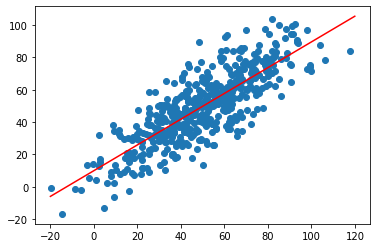

In [6]:
plt.scatter(x, y)
plt.plot(grid_x, grid_y, "r")
plt.show()

# Randomized treatment

In [7]:
mask = np.random.rand(len(y)) > 0.5
index_treat = mask.astype(int).nonzero()
index_cntrl = (~mask).astype(int).nonzero()
y_random = ops.index_update(y, index_treat, y[index_treat] + 10)

In [12]:
def linear_regression_treatment(x, mask, y=None):
    a = numpyro.sample("a", dist.Normal(0, 10))
    b = numpyro.sample("b", dist.Normal(0, 10))
    t = numpyro.sample("t", dist.Normal(0 ,10))
    sigma = numpyro.sample("sigma", dist.HalfCauchy(10))
    numpyro.sample("y", dist.Normal(a * x + b + mask.astype(int) * t, sigma), obs=y)

In [13]:
rng_key, rng_key_infer = random.split(rng_key)

kernel = infer.NUTS(linear_regression_treatment)
mcmc = infer.MCMC(kernel, num_warmup=500, num_samples=500)
mcmc.run(rng_key_infer, x, mask, y_random)
posterior_samples = mcmc.get_samples()

grid_y_treat = posterior_samples["a"].mean() * grid_x + posterior_samples["b"].mean() + posterior_samples["t"].mean()
grid_y_cntrl = posterior_samples["a"].mean() * grid_x + posterior_samples["b"].mean()

sample: 100%|██████████| 1000/1000 [00:04<00:00, 201.52it/s, 7 steps of size 2.50e-01. acc. prob=0.93]


In [20]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.80      0.03      0.80      0.75      0.84    227.91      1.00
         b     10.03      1.47     10.05      7.81     12.50    213.56      1.00
     sigma     12.83      0.42     12.81     12.14     13.51    445.64      1.00
         t      9.30      1.13      9.35      7.43     10.92    258.31      1.00

Number of divergences: 0


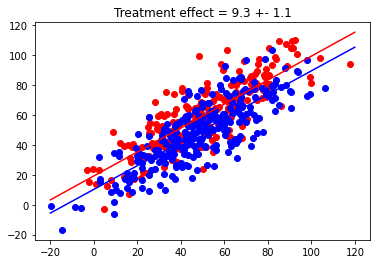

In [19]:
plt.scatter(x[index_treat], y_random[index_treat], color="r")
plt.plot(grid_x, grid_y_treat, "r")

plt.scatter(x[index_cntrl], y_random[index_cntrl], color="b")
plt.plot(grid_x, grid_y_contrl, "b")

plt.title(f"Treatment effect = {posterior_samples['t'].mean():.1f} +- {posterior_samples['t'].std():.1f}")
plt.show()

# Unbalanced treatment

In [31]:
rng_key, rng_key_unbld = random.split(rng_key)
z = dist.Bernoulli(1 / (1 + jnp.exp((x - 50) / 10))).sample(rng_key_unbld)
mask = z == 1

index_treat = mask.astype(int).nonzero()
index_cntrl = (~mask).astype(int).nonzero()
y_unbld = ops.index_update(y, index_treat, y[index_treat] + 10)

In [33]:
def linear_regression_treatment(x, z, y=None):
    a = numpyro.sample("a", dist.Normal(0, 10))
    b = numpyro.sample("b", dist.Normal(0, 10))
    t = numpyro.sample("t", dist.Normal(0 ,10))
    sigma = numpyro.sample("sigma", dist.HalfCauchy(10))
    numpyro.sample("y", dist.Normal(a * x + b + z * t, sigma), obs=y)

In [34]:
rng_key, rng_key_infer = random.split(rng_key)

kernel = infer.NUTS(linear_regression_treatment)
mcmc = infer.MCMC(kernel, num_warmup=500, num_samples=500)
mcmc.run(rng_key_infer, x, z, y_unbld)
posterior_samples = mcmc.get_samples()

grid_y_treat = posterior_samples["a"].mean() * grid_x + posterior_samples["b"].mean() + posterior_samples["t"].mean()
grid_y_cntrl = posterior_samples["a"].mean() * grid_x + posterior_samples["b"].mean()

sample: 100%|██████████| 1000/1000 [00:05<00:00, 174.51it/s, 7 steps of size 1.89e-01. acc. prob=0.95]


In [35]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.80      0.04      0.80      0.75      0.86    104.23      1.00
         b      9.45      2.36      9.34      5.88     13.47    102.39      1.00
     sigma     12.84      0.43     12.84     12.09     13.42    292.98      1.00
         t     10.43      1.53     10.48      7.84     12.69    134.06      1.00

Number of divergences: 0


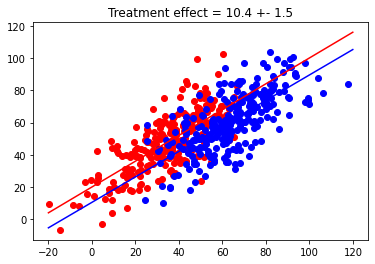

In [37]:
plt.scatter(x[index_treat], y_unbld[index_treat], color="r")
plt.plot(grid_x, grid_y_treat, "r")

plt.scatter(x[index_cntrl], y_unbld[index_cntrl], color="b")
plt.plot(grid_x, grid_y_contrl, "b")

plt.title(f"Treatment effect = {posterior_samples['t'].mean():.1f} +- {posterior_samples['t'].std():.1f}")
plt.show()